In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns 


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
try:
    combined_df = pd.read_csv('combined_dataset.csv')
except FileNotFoundError:
    print("FEHLER: Stelle sicher, dass 'combined_dataset.csv' im selben Verzeichnis liegt.")
    raise

ticker_symbol = 'aapl'
aapl_df = combined_df[combined_df['Ticker'] == ticker_symbol].copy()

if aapl_df.empty:
    print(f"FEHLER: Keine Daten für Ticker '{ticker_symbol}' gefunden.")
    raise ValueError(f"Ticker {ticker_symbol} nicht im Datensatz.")
else:
    print(f"Daten erfolgreich für Ticker '{ticker_symbol}' gefiltert: {aapl_df.shape[0]} Zeilen gefunden.")

aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df.set_index('Date', inplace=True)
aapl_df.sort_index(inplace=True)

Daten erfolgreich für Ticker 'aapl' gefiltert: 8364 Zeilen gefunden.


In [7]:
aapl_df['Log_Return'] = np.log(aapl_df['Close'] / aapl_df['Close'].shift(1))

aapl_df['SMA5'] = aapl_df['Close'].rolling(window=5).mean()
aapl_df['SMA20'] = aapl_df['Close'].rolling(window=20).mean()

aapl_df['Return_Lag1'] = aapl_df['Log_Return'].shift(1)
aapl_df['Return_Lag2'] = aapl_df['Log_Return'].shift(2)
aapl_df['Return_Lag5'] = aapl_df['Log_Return'].shift(5)

aapl_df['Target'] = aapl_df['Log_Return'].shift(-1)

print("Feature Engineering abgeschlossen (Log Returns, SMAs, Lagged Returns, Target).")

Feature Engineering abgeschlossen (Log Returns, SMAs, Lagged Returns, Target).


In [8]:
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'SMA5', 'SMA20',
            'Return_Lag1', 'Return_Lag2', 'Return_Lag5']
target_variable = 'Target'

initial_rows = aapl_df.shape[0]
aapl_df.dropna(subset=features + [target_variable], inplace=True)
final_rows = aapl_df.shape[0]
print(f"\nZeilen vor NaN-Entfernung (AAPL): {initial_rows}")
print(f"Zeilen nach NaN-Entfernung (AAPL): {final_rows} ({initial_rows - final_rows} entfernt)")

X = aapl_df[features]
y = aapl_df[target_variable]

split_date = '2016-12-31'
train_mask = X.index <= split_date
test_mask = X.index > split_date

X_train_raw = X[train_mask]
y_train = y[train_mask]
X_test_raw = X[test_mask]
y_test = y[test_mask]

if X_train_raw.empty or X_test_raw.empty:
    print("FEHLER: AAPL Trainings- oder Testset ist leer nach NaN-Entfernung.")
else:
    print(f"\nAAPL Trainingsdaten Grösse (Features): {X_train_raw.shape[0]} Zeilen")
    print(f"AAPL Testdaten Grösse (Features): {X_test_raw.shape[0]} Zeilen")


Zeilen vor NaN-Entfernung (AAPL): 8364
Zeilen nach NaN-Entfernung (AAPL): 8344 (20 entfernt)

AAPL Trainingsdaten Grösse (Features): 8127 Zeilen
AAPL Testdaten Grösse (Features): 217 Zeilen


In [9]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train = pd.DataFrame(X_train, columns=features, index=X_train_raw.index)
X_test = pd.DataFrame(X_test, columns=features, index=X_test_raw.index)

print("Features skaliert (MinMaxScaler).")


Features skaliert (MinMaxScaler).


In [10]:
rf_model = RandomForestRegressor(n_estimators=200,
                                 random_state=42,
                                 n_jobs=-1,
                                 max_depth=None,
                                 min_samples_leaf=10,
                                 max_features='sqrt',
                                 oob_score=True
                                )

print("\nTrainiere das RandomForestRegressor Modell (nur AAPL, mit Log-Returns)...")
if not X_train.empty and not y_train.empty:
    rf_model.fit(X_train, y_train)
    print(f"Modell Training abgeschlossen. OOB Score: {rf_model.oob_score_:.4f}")
else:
    print("FEHLER: Trainingsdaten sind leer, Training kann nicht durchgeführt werden.")


Trainiere das RandomForestRegressor Modell (nur AAPL, mit Log-Returns)...
Modell Training abgeschlossen. OOB Score: -0.0210


In [11]:
predictions_log_return = None
results_df = pd.DataFrame()

if 'rf_model' in locals() and hasattr(rf_model, 'predict') and not X_test.empty:
    print("\nErstelle Vorhersagen für das AAPL Test-Set (Log-Returns)...")
    predictions_log_return = rf_model.predict(X_test)

    actual_closes_test = aapl_df.loc[X_test_raw.index, 'Close']
    try:
        last_train_index = X_train_raw.index[-1]
        last_train_close = aapl_df.loc[last_train_index, 'Close']
    except IndexError:
        print("Warnung: Konnte letzten Trainingskurs nicht finden, verwende Fallback.")
        last_train_close = aapl_df['Close'].iloc[len(X_train_raw) - 1]

    previous_actual_closes = actual_closes_test.shift(1).fillna(last_train_close)
    previous_actual_closes = previous_actual_closes.reindex(X_test_raw.index)
    predicted_closes = previous_actual_closes * np.exp(predictions_log_return)

    results_df = pd.DataFrame({
        'Actual_Close': actual_closes_test,
        'Predicted_Close': predicted_closes,
        'Actual_Log_Return': y_test,
        'Predicted_Log_Return': predictions_log_return
    }, index=y_test.index)
    print("Vorhersagen für Log-Returns und rekonstruierte Kurse erstellt.")

else:
    print("\nFEHLER: Modell nicht trainiert oder keine Testdaten vorhanden. Vorhersage übersprungen.")


Erstelle Vorhersagen für das AAPL Test-Set (Log-Returns)...
Vorhersagen für Log-Returns und rekonstruierte Kurse erstellt.


## Aufgabe 4


Feature Importances (Random Forest):
       Feature  Importance
7  Return_Lag1    0.131594
9  Return_Lag5    0.129910
4       Volume    0.125723
8  Return_Lag2    0.124197
6        SMA20    0.100197
5         SMA5    0.084167
3        Close    0.078441
2          Low    0.075786
1         High    0.075587
0         Open    0.074398


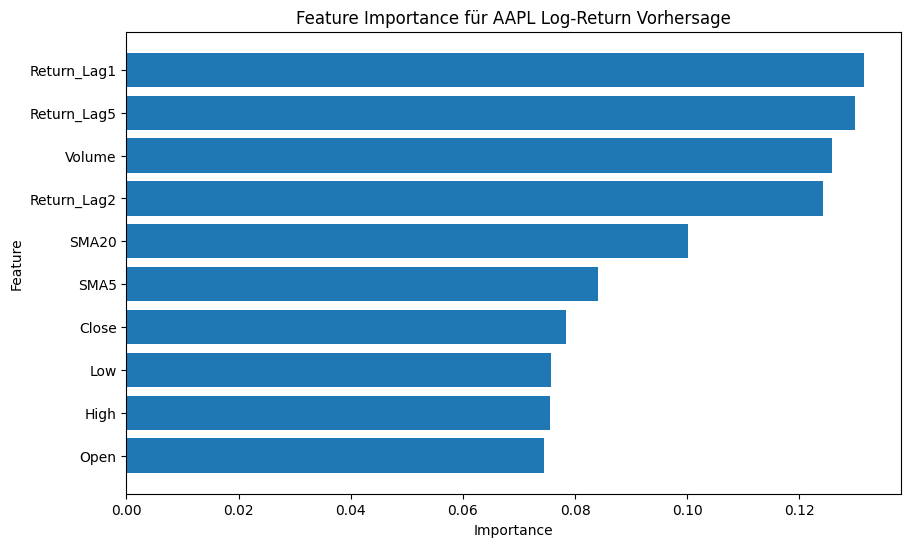


Interpretation:
Die obige Tabelle und Grafik zeigen die relative Wichtigkeit jedes Features für die Vorhersagen des Modells.
Das wichtigste Feature ist 'Return_Lag1' mit einer Importance von 0.1316.
Features mit höherer Importance haben einen größeren Einfluss auf die Modellentscheidungen.


In [12]:
if 'rf_model' in locals() and hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    feature_names = features # Aus Zelle 3
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\nFeature Importances (Random Forest):")
    print(feature_importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance für AAPL Log-Return Vorhersage')
    plt.gca().invert_yaxis()
    plt.show()

    print("\nInterpretation:")
    print("Die obige Tabelle und Grafik zeigen die relative Wichtigkeit jedes Features für die Vorhersagen des Modells.")
    print(f"Das wichtigste Feature ist '{feature_importance_df.iloc[0]['Feature']}' mit einer Importance von {feature_importance_df.iloc[0]['Importance']:.4f}.")
    print("Features mit höherer Importance haben einen größeren Einfluss auf die Modellentscheidungen.")
else:
    print("Modell ('rf_model') wurde nicht trainiert oder unterstützt keine Feature Importances.")

In [14]:
if predictions_log_return is not None and not y_test.empty:

    mae_log = mean_absolute_error(y_test, predictions_log_return)
    rmse_log = np.sqrt(mean_squared_error(y_test, predictions_log_return))
    r2_log = r2_score(y_test, predictions_log_return)

    print(f"\nMetriken berechnet auf den vorhergesagten Log-Returns:")
    print(f"Mean Absolute Error (MAE): {mae_log:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_log:.6f}")
    print(f"R² (Bestimmtheitsmaß): {r2_log:.4f}")

    if not results_df.empty:
         mae_price = mean_absolute_error(results_df['Actual_Close'], results_df['Predicted_Close'])
         rmse_price = np.sqrt(mean_squared_error(results_df['Actual_Close'], results_df['Predicted_Close']))
         r2_price = r2_score(results_df['Actual_Close'], results_df['Predicted_Close'])

         print(f"\nMetriken berechnet auf den rekonstruierten Kursen:")
         print(f"Mean Absolute Error (MAE): {mae_price:.4f}")
         print(f"Root Mean Squared Error (RMSE): {rmse_price:.4f}")
         print(f"R² (Bestimmtheitsmaß): {r2_price:.4f}")
    else:
        print("\nRekonstruierte Kurse nicht verfügbar für Metrikberechnung.")
        mae_price = np.nan # Definieren, um Fehler zu vermeiden

    print("\nAuswahl und Begründung der Metrik:")
    print("Für Regressionsprobleme wie die Vorhersage von Log-Returns sind MAE und RMSE gängige Metriken.")
    print("- MAE (Mean Absolute Error): Misst den durchschnittlichen absoluten Fehler. Ist in der Einheit der Zielvariable (Log-Return) und daher oft gut interpretierbar.")
    print("- RMSE (Root Mean Squared Error): Bestraft größere Fehler stärker als MAE. Ebenfalls in der Einheit der Zielvariable.")
    print("- R² (Bestimmtheitsmaß): Gibt an, wie viel Prozent der Varianz der Zielvariable durch das Modell erklärt wird. Werte nahe 1 sind gut, Werte nahe 0 oder negativ deuten auf ein schlechtes Modell hin.")

    print("\nGewählte Metrik: MAE für die Log-Returns.")
    print("Begründung: MAE ist robust gegenüber Ausreißern und direkt in der Einheit der Renditen interpretierbar, was den durchschnittlichen Vorhersagefehler greifbar macht.")
    print(f"Berechneter MAE (Log-Returns): {mae_log:.6f}")
    if not np.isnan(mae_price):
        print("\nZur besseren finanziellen Interpretation wird oft auch der MAE auf den rekonstruierten Kursen betrachtet:")
        print(f"Berechneter MAE (Kurse): {mae_price:.4f}")

else:
    print("Vorhersagen ('predictions_log_return') oder Testdaten ('y_test') nicht gefunden. Metrikberechnung übersprungen.")
    mae_log = np.nan
    mae_price = np.nan


Metriken berechnet auf den vorhergesagten Log-Returns:
Mean Absolute Error (MAE): 0.008803
Root Mean Squared Error (RMSE): 0.012348
R² (Bestimmtheitsmaß): -0.2332

Metriken berechnet auf den rekonstruierten Kursen:
Mean Absolute Error (MAE): 1.2936
Root Mean Squared Error (RMSE): 1.8243
R² (Bestimmtheitsmaß): 0.9807

Auswahl und Begründung der Metrik:
Für Regressionsprobleme wie die Vorhersage von Log-Returns sind MAE und RMSE gängige Metriken.
- MAE (Mean Absolute Error): Misst den durchschnittlichen absoluten Fehler. Ist in der Einheit der Zielvariable (Log-Return) und daher oft gut interpretierbar.
- RMSE (Root Mean Squared Error): Bestraft größere Fehler stärker als MAE. Ebenfalls in der Einheit der Zielvariable.
- R² (Bestimmtheitsmaß): Gibt an, wie viel Prozent der Varianz der Zielvariable durch das Modell erklärt wird. Werte nahe 1 sind gut, Werte nahe 0 oder negativ deuten auf ein schlechtes Modell hin.

Gewählte Metrik: MAE für die Log-Returns.
Begründung: MAE ist robust gege


Wahrheitsmatrix (Confusion Matrix) für die Richtungsvorhersage (1=Up, 0=Down/Flat):
         Predicted Down/Flat  | Predicted Up
-------------------------------------------------
Actual Down/Flat | 91                   | 3              
Actual Up        | 120                  | 3              


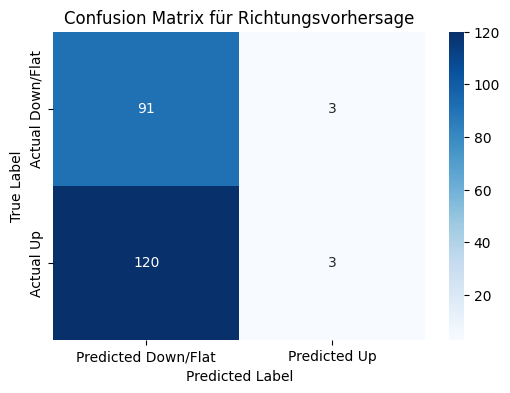


Recall (für Kursanstiege, Klasse 1): 0.0244
Precision (für Kursanstiege, Klasse 1): 0.5000

Gesamter Klassifikationsbericht:
               precision    recall  f1-score   support

Down/Flat (0)       0.43      0.97      0.60        94
       Up (1)       0.50      0.02      0.05       123

     accuracy                           0.43       217
    macro avg       0.47      0.50      0.32       217
 weighted avg       0.47      0.43      0.28       217



In [16]:
if predictions_log_return is not None and not y_test.empty:
    threshold = 0
    y_test_binary = (y_test > threshold).astype(int)        
    predictions_binary = (predictions_log_return > threshold).astype(int) 

    print("\nWahrheitsmatrix (Confusion Matrix) für die Richtungsvorhersage (1=Up, 0=Down/Flat):")
    cm = confusion_matrix(y_test_binary, predictions_binary)
    print("         Predicted Down/Flat  | Predicted Up")
    print("-------------------------------------------------")
    print(f"Actual Down/Flat | {cm[0, 0]:<20} | {cm[0, 1]:<15}")
    print(f"Actual Up        | {cm[1, 0]:<20} | {cm[1, 1]:<15}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down/Flat', 'Predicted Up'],
                yticklabels=['Actual Down/Flat', 'Actual Up'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix für Richtungsvorhersage')
    plt.show()

    recall = recall_score(y_test_binary, predictions_binary, pos_label=1, zero_division=0)
    precision = precision_score(y_test_binary, predictions_binary, pos_label=1, zero_division=0)

    print(f"\nRecall (für Kursanstiege, Klasse 1): {recall:.4f}")
    print(f"Precision (für Kursanstiege, Klasse 1): {precision:.4f}")

    print("\nGesamter Klassifikationsbericht:")
    print(classification_report(y_test_binary, predictions_binary, target_names=['Down/Flat (0)', 'Up (1)'], zero_division=0))

else:
    print("Vorhersagen ('predictions_log_return') oder Testdaten ('y_test') nicht gefunden. Berechnung übersprungen.")
    recall = np.nan
    precision = np.nan

Mein Modell hat schlussendlich nicht allzu gut funktioniert, was aber auch vorhersehbar gewesen ist, denn es ist ja so das es noch niemand auf der Welt geschafft hat Aktienkurse konsistent vorherzusagen. Aufgrund des leicht negativen R² lässt sich schliessen, dass es effizienter gewesen wäre den Durchschnitt zu nehmen um die zukünftigen Kurse zu berechnen. Basierend auf dem Precisionmass, sieht man das es 50/50 ist das die vorhergesagten Kursveränderungen auch eintreffen, somit wäre es mehr oder weniger dasselbe ob man auf das Modell vertraut oder ob man eine Münze wirft. Zum einen hat es einen Einfluss darauf das das Modell nicht weiss was gerade in der Welt passiert denn dies hat starke auswirkungen auf den Aktienmarkt. Zum anderm könnte es sein das die Entscheidungsbäume nicht tief genug waren obwohl ich diese bereits angepasst habe.